In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/t.cri.yliang/labshare/GitHub/misc-tools/pyplot_tool/')
import plot_tools
sys.path.insert(0, '/home/t.cri.yliang/labshare/GitHub/mixqtl-gtex/postprocessing/functional_enrichment/')
import functional_enrichment
import io
import subprocess
import os

In [3]:
def merge(df, dfn, extract_col_dict, by_cols):
    tmp = dfn[list(extract_col_dict.keys()) + by_cols]
    tmp = tmp.rename(columns=extract_col_dict)
    if df is None:
        return tmp
    else:
        return pd.merge(df, tmp, on=by_cols)
def trim_dot(dd):
    return [ i.split('.')[0] for i in dd ]

def get_pval_mixqtl(p1, p2, p3):
    o = p1.copy()
    o[np.isnan(o)] = p2[np.isnan(o)]
    o[np.isnan(o)] = p3[np.isnan(o)]
    return o
def rename_col(df, method):
    if method == 'rasqual':
        return df.rename(columns={'Feature_ID': 'phenotype_id', 'rs_ID': 'variant_id'})
    elif method == 'eqtl':
        if 'gene_id' in df.columns:
            df['gene_id'] = trim_dot(df['gene_id'])
        return df.rename(columns={'gene_id': 'phenotype_id', 'pval_nominal': 'pval', 'slope': 'bhat'})
    elif method == 'mixqtl':
        return df
def clean_up_rasqual(df):
    # clean up rasqual
    tmp = df
    tmp = tmp[ tmp['Convergence_status_0success'] == 0 ].reset_index(drop=True)

    tmp['pval'] = scipy.stats.chi2.sf(tmp['Chi_square_statistic_2_x_log_Likelihood_ratio'], 1)
    tmp['bhat'] = np.log(tmp.Effect_size_Pi / (1 - tmp.Effect_size_Pi))
    df = rename_col(tmp, 'rasqual')
    df = df[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    return df
def clean_up(df, method):
    df = rename_col(df, method)
    if method == 'mixqtl':
        # clean up mixqtl
        tmp = df
        tmp['pval'] = get_pval_mixqtl(tmp.pval_meta, tmp.pval_trc, tmp.pval_asc)
        tmp['bhat'] = get_pval_mixqtl(tmp.beta_meta, tmp.beta_trc, tmp.beta_asc)
        return tmp[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    elif method == 'eqtl':
        # clean up eqtl
        return df[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    elif method == 'rasqual':
        return clean_up_rasqual(df)
def read_from_cmd(cmd, kwargs={}):
    print(cmd)
    process = subprocess.check_output([cmd], stderr=subprocess.STDOUT, shell=True)
    csv = io.StringIO()
    for line in process.decode().split('\n'):
        csv.write(line.strip('"\n') + '\n')
    csv.seek(0)
    data = pd.read_csv(csv, **kwargs)
    csv.close()
    return data

In [4]:
file = {}
chr_num = 22

file['rasqual'] = f'/home/t.cri.yliang/scratch/run-rasqual-results/run_whole_blood/rasqual_output.Whole_Blood.chr{chr_num}.parquet'
file['mixqtl'] = f'/home/t.cri.yliang/scratch/mixQTL-GTExV8/mixqtl/Whole_Blood/mixqtl.Whole_Blood_GTEx_eGene.cis_qtl_pairs.mixQTL.chr{chr_num}.parquet'
file['eqtl'] = f'/home/t.cri.yliang/scratch/mixQTL-GTExV8/split_eqtl/Whole_Blood/eqtl_allpairs.chr{chr_num}.parquet'

cache_file = 'cache_results_on_whole_blood.pkl.gz'
chrs = [ 22 ]

In [5]:
# get the list of variants
df_pairs = {}
for chr_num in chrs:
    fn = file['rasqual']
    fn = fn.format(chr_num=chr_num)
    dd = pd.read_parquet(fn)
    df_pairs[chr_num] = clean_up_rasqual(dd)

/home/t.cri.yliang/miniconda2/envs/mixqtl/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


In [6]:
import gzip
import pickle
if not functional_enrichment.file_exists(cache_file):
    df = {}

    for i, fn in file.items():
        print(i)
        df[i] = []
        for chr_num in chrs:
            print(f'chr{chr_num} \r', end='')
            fn = file[i]
            fn = fn.format(chr_num=chr_num)
            tmp = pd.read_parquet(fn)
            tmp = rename_col(tmp, i)
            tmp = pd.merge(df_pairs[chr_num][['phenotype_id', 'variant_id']], tmp, on=['phenotype_id', 'variant_id'])
            tmp = clean_up(tmp, i)
            df[i].append(tmp)
        df[i] = pd.concat(df[i], axis=0)
        print('\n')
    with gzip.open(cache_file, 'wb') as f:
        pickle.dump(df, f)
else:
    with gzip.open(cache_file, 'rb') as f:
        df = pickle.load(f)

rasqual


/home/t.cri.yliang/miniconda2/envs/mixqtl/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log




mixqtl
chr22 

eqtl
chr22 



In [8]:
# merge all three
df_p = None
df_b = None
df_p = merge(df_p, df['rasqual'], extract_col_dict={'pval': 'rasqual'}, by_cols=['phenotype_id', 'variant_id'])
df_p = merge(df_p, df['mixqtl'], extract_col_dict={'pval': 'mixqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_p = merge(df_p, df['eqtl'], extract_col_dict={'pval': 'eqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['rasqual'], extract_col_dict={'bhat': 'rasqual'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['mixqtl'], extract_col_dict={'bhat': 'mixqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['eqtl'], extract_col_dict={'bhat': 'eqtl'}, by_cols=['phenotype_id', 'variant_id'])

/home/t.cri.yliang/miniconda2/envs/mixqtl/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


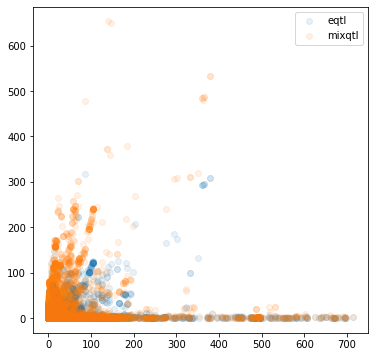

In [13]:
# subset
ind_sub = np.random.randint(0, df_p.shape[0], size=50000)
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [ -np.log(df_p['rasqual'][ind_sub]), -np.log(df_p['rasqual'][ind_sub]) ],
    [ -np.log(df_p['eqtl'][ind_sub]), -np.log(df_p['mixqtl'][ind_sub]) ],
    ['eqtl', 'mixqtl'],
    axe,
    {'alpha': 0.1}
)

Text(0, 0.5, 'Log fold change estimated from mixQTL')

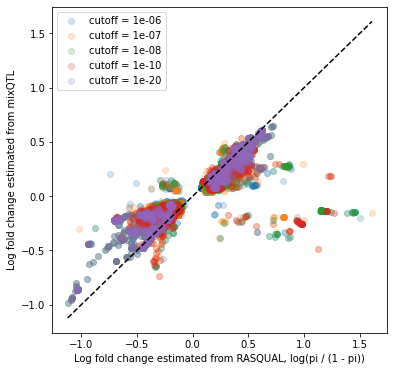

In [14]:
# both signif
inds = []
cutoffs = [ 1e-20, 1e-10, 1e-8, 1e-7, 1e-6 ]
for cutoff in cutoffs:
    if len(inds) > 0:
        inds.append(~inds[-1] & (df_p['mixqtl'] < cutoff) & (df_p['rasqual'] < cutoff))
    else:
        inds.append((df_p['mixqtl'] < cutoff) & (df_p['rasqual'] < cutoff))

fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [ df_b['rasqual'][ind] for ind in reversed(inds) ],
    [ df_b['mixqtl'][ind] for ind in reversed(inds) ],
    [ 'cutoff = {}'.format(co) for co in reversed(cutoffs) ],
    axe,
    {'alpha': 0.2}
)
axe.set_xlabel('Log fold change estimated from RASQUAL, log(pi / (1 - pi))')
axe.set_ylabel('Log fold change estimated from mixQTL')

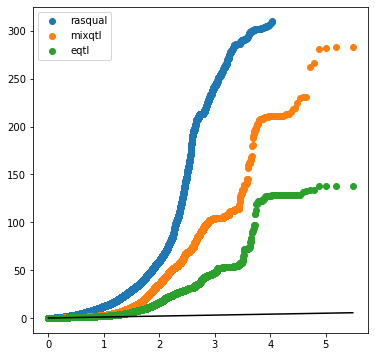

In [12]:
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.qqplot(
    [df_p['rasqual'], df_p['mixqtl'], df_p['eqtl']],
    ['rasqual', 'mixqtl', 'eqtl'],
    axe
)